### Modeling with Frequencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from project_functions import regression_metrics, scale_features

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import (log_loss,
                            roc_auc_score, 
                            recall_score, 
                            precision_score, 
                            average_precision_score, 
                            f1_score, classification_report, 
                            accuracy_score, plot_roc_curve, 
                            plot_precision_recall_curve, 
                            plot_confusion_matrix
                        )

In [2]:
freq_flights = pd.read_csv("Features_with_frequencies.csv")

In [3]:
freq_flights.head()

,Unnamed: 0,fl_date,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,...,destination_id_frequency,origin_id_frequency,mkt_frequency,branded_frequency,op_frequency,flight_num_frequency,Cloudy,Rainy,Snowy,Sunny
0,0,2018-12-01,1229,1337.0,68.0,12.0,1349.0,1452.0,9.0,1355,...,0.037064,0.003389,0.269857,0.147168,0.030035,0.000132,0,1,0,0
1,1,2018-12-01,1945,1941.0,-4.0,15.0,1956.0,2209.0,6.0,2244,...,0.022009,0.019777,0.025626,0.025626,0.025626,0.000269,1,0,0,0
2,2,2018-12-01,1110,1107.0,-3.0,32.0,1139.0,1844.0,12.0,1855,...,0.019954,0.022224,0.025626,0.025626,0.025626,0.000380,0,0,0,1
3,3,2018-12-01,1739,1736.0,-3.0,11.0,1747.0,1911.0,4.0,1930,...,0.014786,0.048256,0.025626,0.025626,0.025626,0.000345,0,1,0,0
4,4,2018-12-01,930,926.0,-4.0,12.0,938.0,1607.0,7.0,1649,...,0.048839,0.030977,0.025626,0.025626,0.025626,0.000345,0,1,0,0


In [4]:
freq_flights.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# not using fl_date
freq_flights.drop(['dep_delay', 'fl_date'], axis=1, inplace=True)

In [6]:
categoric = ['diverted', 'Cloudy', 'Rainy', 'Snowy', 'Sunny']
numeric = list(set(freq_flights.columns) - set(categoric))

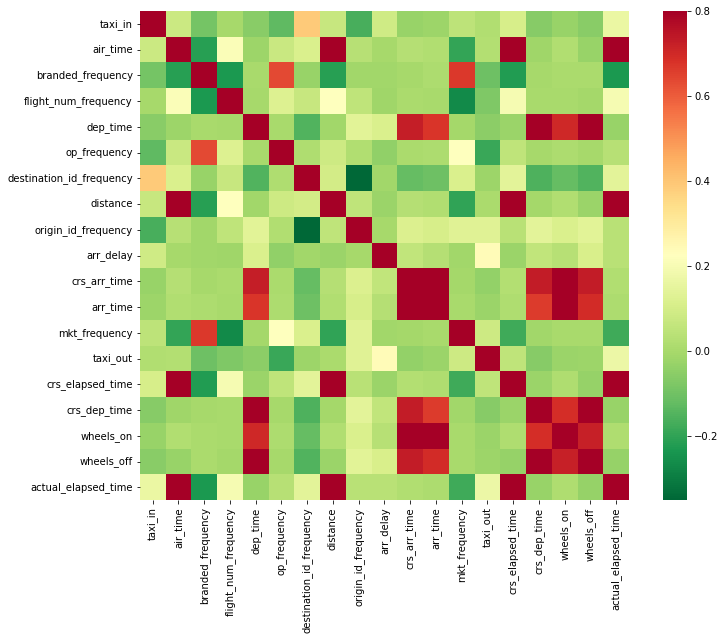

In [7]:
# check most correlated numeric variables with arr_delay
corrmat = freq_flights[numeric].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="RdYlGn_r")

plt.show()

In [8]:
numeric.remove('arr_delay')

# Modeling

In [9]:
# separate target and predictors
y = freq_flights['arr_delay']
X = freq_flights.drop('arr_delay', axis=1)

In [10]:
seed = 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [11]:
scaler = StandardScaler()

X_train_scaled, X_test_scaled = scale_features(X_train, X_test, numeric, categoric, scaler)

#### Linear Regression

In [12]:
line_reg = LinearRegression()

line_reg.fit(X_train_scaled, y_train)

yhat_line = line_reg.predict(X_test_scaled)

In [13]:
regression_metrics(y_test, yhat_line)

R^2: 0.18450019569535914
Mean Squared Error: 1636.2871866071116
Mean Absolute Error: 17.905996017475704
Root MSE: 40.451046792476355


#### Random Forest

In [14]:
rfc = RandomForestRegressor(n_estimators=10, max_depth=8, random_state=seed)

rfc.fit(X_train_scaled, y_train)

yhat_rfc = rfc.predict(X_test_scaled)

In [15]:
regression_metrics(y_test, yhat_rfc)

R^2: 0.6453920159942121
Mean Squared Error: 711.5151928111238
Mean Absolute Error: 16.06027566330537
Root MSE: 26.67424212252569


#### Naive Bayes

In [16]:
gauss = GaussianNB()

gauss.fit(X_train_scaled, y_train) 

yhat_nb = gauss.predict(X_test_scaled)

In [17]:
regression_metrics(y_test, yhat_nb)

R^2: -136.71416429426012
Mean Squared Error: 276321.24650372774
Mean Absolute Error: 489.6766931425031
Root MSE: 525.6626736831594


# Submission
We will be using the Random Forest Regressor to predict the arrival delay because it has consistently performed the best. First, let's do a little prep on the test data.

In [18]:
# load and apply engineered features to the test data we are trying to predict 
import pandas as pd
test_df = pd.read_csv('Johns work/csv_file/Test_dataframe.csv')
dest_airport_freq = test_df.groupby('dest_airport_id').size()/len(test_df)
test_df.loc[:, 'destination_id_frequency'] = test_df['dest_airport_id'].map(dest_airport_freq)

def make_frequency(Feature, New_Feature):
    '''
    This function takes in the name of the column you want to use and the name of the column you want to create
    This function returns a new column with frequencies encoded as categories
    '''
    frequency = test_df.groupby(Feature).size()/len(test_df)
    test_df.loc[:, New_Feature] = test_df[Feature].map(frequency)
     
    return

make_frequency('dest_airport_id', 'destination_id_frequency')
make_frequency('origin_airport_id', 'origin_id_frequency')
make_frequency('mkt_unique_carrier', 'mkt_frequency')
make_frequency('branded_code_share', 'branded_frequency')
make_frequency('op_unique_carrier', 'op_frequency')
make_frequency('op_carrier_fl_num', 'flight_num_frequency')

originals = ['dest_airport_id', 'origin_airport_id', 'mkt_unique_carrier', 'branded_code_share', 'op_unique_carrier', 'op_carrier_fl_num']
test_df = test_df.drop(originals, axis = 1)

In [19]:
# test_df.head()

In [20]:
test_df.columns.tolist()

['fl_date',
 'mkt_carrier',
 'mkt_carrier_fl_num',
 'tail_num',
 'origin',
 'origin_city_name',
 'dest',
 'dest_city_name',
 'crs_dep_time',
 'crs_arr_time',
 'dup',
 'crs_elapsed_time',
 'flights',
 'distance',
 'destination_id_frequency',
 'origin_id_frequency',
 'mkt_frequency',
 'branded_frequency',
 'op_frequency',
 'flight_num_frequency']

In [21]:
# columns that weren't used in our dataframe but needed for submission
not_for_test = (test_df.columns).difference(freq_flights.columns)

not_for_test

Index(['dest', 'dest_city_name', 'dup', 'fl_date', 'flights', 'mkt_carrier',
       'mkt_carrier_fl_num', 'origin', 'origin_city_name', 'tail_num'],
      dtype='object')

In [23]:
# columns that are in test_df AND freq_flights
# retrieving remaining columns from test_df
for_test = list(set(test_df.columns) - set(test_df[not_for_test]))

for_test

['crs_dep_time',
 'flight_num_frequency',
 'branded_frequency',
 'op_frequency',
 'destination_id_frequency',
 'distance',
 'origin_id_frequency',
 'crs_arr_time',
 'mkt_frequency',
 'crs_elapsed_time']

In [24]:
# columns that we can't use
# taking out weather conditions because we don't have the weather for the test data
rm_from_flights = ['dep_time', 
                   'taxi_out', 
                   'wheels_off', 
                   'wheels_on',
                   'taxi_in',
                   'arr_time',
                   'arr_delay',
                   'diverted',
                   'actual_elapsed_time',
                   'air_time',
                   'Rainy', 
                   'Snowy', 
                   'Sunny',
                   'Cloudy']

In [25]:
# remove unusable columns from freq_flights
freq_flights_new = freq_flights.drop(rm_from_flights, axis=1)

In [26]:
sorted(for_test) == sorted(freq_flights_new.columns.tolist())

True

Now that the columns match, we will retrain the model and predict the arrival delays for the first week of January 2020!

In [27]:
# columns need to be in the same order
sorted_flights_cols = sorted(freq_flights_new.columns.tolist())

freq_flights_new = freq_flights_new[sorted_flights_cols]
for_test = sorted(for_test)

In [28]:
# scale both datasets
scaler = StandardScaler()

scaler.fit_transform(freq_flights_new)

test_df_scaled = scaler.transform(test_df[for_test])

In [29]:
final = rfc

final.fit(freq_flights_new, y)

RandomForestRegressor(max_depth=8, n_estimators=10, random_state=100)

In [30]:
predictions = final.predict(test_df[for_test])

In [31]:
submission_frame = test_df[not_for_test]

submission_frame['predicted_delay'] = predictions

C:\Users\vanessa\AppData\Local\Temp\ipykernel_1748\2235819650.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_frame['predicted_delay'] = predictions


In [32]:
submission_frame.head()

,dest,dest_city_name,dup,fl_date,flights,mkt_carrier,mkt_carrier_fl_num,origin,origin_city_name,tail_num,predicted_delay
0,SFO,"San Francisco, CA",N,2020-01-01 00:00:00,1,WN,5888,ONT,"Ontario, CA",N951WN,4.204898
1,SFO,"San Francisco, CA",N,2020-01-01 00:00:00,1,WN,6276,ONT,"Ontario, CA",N467WN,1.937917
2,SJC,"San Jose, CA",N,2020-01-01 00:00:00,1,WN,4598,ONT,"Ontario, CA",N7885A,3.344711
3,SJC,"San Jose, CA",N,2020-01-01 00:00:00,1,WN,4761,ONT,"Ontario, CA",N551WN,2.145457
4,SJC,"San Jose, CA",N,2020-01-01 00:00:00,1,WN,5162,ONT,"Ontario, CA",N968WN,-3.253428


In [33]:
# reorganizing
submission_frame['fl_date'] =pd.to_datetime(submission_frame['fl_date'], format='%Y-%m-%d %H:%M:%S')

cols = ['fl_date', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin', 'dest', 'predicted_delay']

C:\Users\vanessa\AppData\Local\Temp\ipykernel_1748\3301575235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_frame['fl_date'] =pd.to_datetime(submission_frame['fl_date'], format='%Y-%m-%d %H:%M:%S')


In [34]:
submission_frame[cols].to_csv('submission.csv', index=False)